# Detecting Time from Analog Clock Images

## Introduction

This project explores a straightforward way to detect time from images of analog clocks by applying traditional computer vision techniques. Instead of relying on deep learning, we’re using classic image processing steps to identify clock hands and determine the time based on their angles.

The process starts with preprocessing the images to enhance contrast and clarity. From there, we locate the clock's center and use line detection methods to find the hands. By calculating their orientations, we can estimate the time with reasonable accuracy. 

One advantage of this approach is that it’s both lightweight and interpretable. Traditional computer vision methods are often simpler and faster, especially for specific, well-defined tasks like this one, which involves detecting angles and positions. The project serves as a practical example of how classical computer vision can effectively solve tasks in image analysis without needing large datasets or training models.

## Limitations

This method, however, has certain limitations. It can struggle in cases where image quality is poor, the clock is occluded, or the lighting conditions vary significantly. Shadows, reflections, and non-standard clock designs can lead to errors in detecting the center or the hands accurately. Additionally, without deep learning's adaptability to diverse visual contexts, this approach is best suited for simpler, standard analog clock images. Despite these limitations, it provides a reliable, resource-efficient solution for well-defined scenarios.

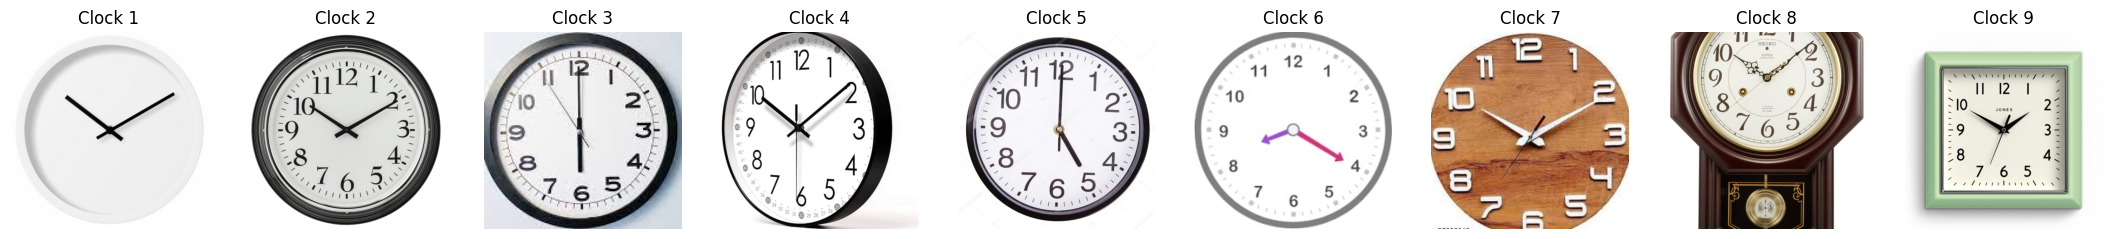

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

IMAGE_SIZE = (640, 640)

# Funzione per caricare e croppare le immagini
def load_images():
    images = []
    for img_path in sorted(os.listdir("./images")):
        if "clock" in img_path and img_path.endswith(".jpg"):
            img = cv2.imread("./images/" + img_path)
            if img is not None:
                # Ritaglia l'immagine per renderla quadrata
                height, width = img.shape[:2]
                side = min(height, width)
                
                # Calcola i margini per centrare il crop
                top = (height - side) // 2
                bottom = top + side
                left = (width - side) // 2
                right = left + side
                
                # Effettua il crop
                img = img[top:bottom, left:right]
                
                # Ridimensiona l'immagine a 640x640
                img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
                images.append(img)
            else:
                print(f"Immagine non trovata: {img_path}")
    return images

# Funzione per mostrare le immagini
def show_images(images):
    plt.figure(figsize=(len(images)*3, 10))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)  # Mostra tutte le immagini in una riga
        plt.title(f"Clock {i+1}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Converte BGR a RGB
        plt.axis('off')  # Nasconde gli assi
    plt.show()

# Carica le immagini
images = load_images()

# Mostra le immagini caricate
show_images(images)

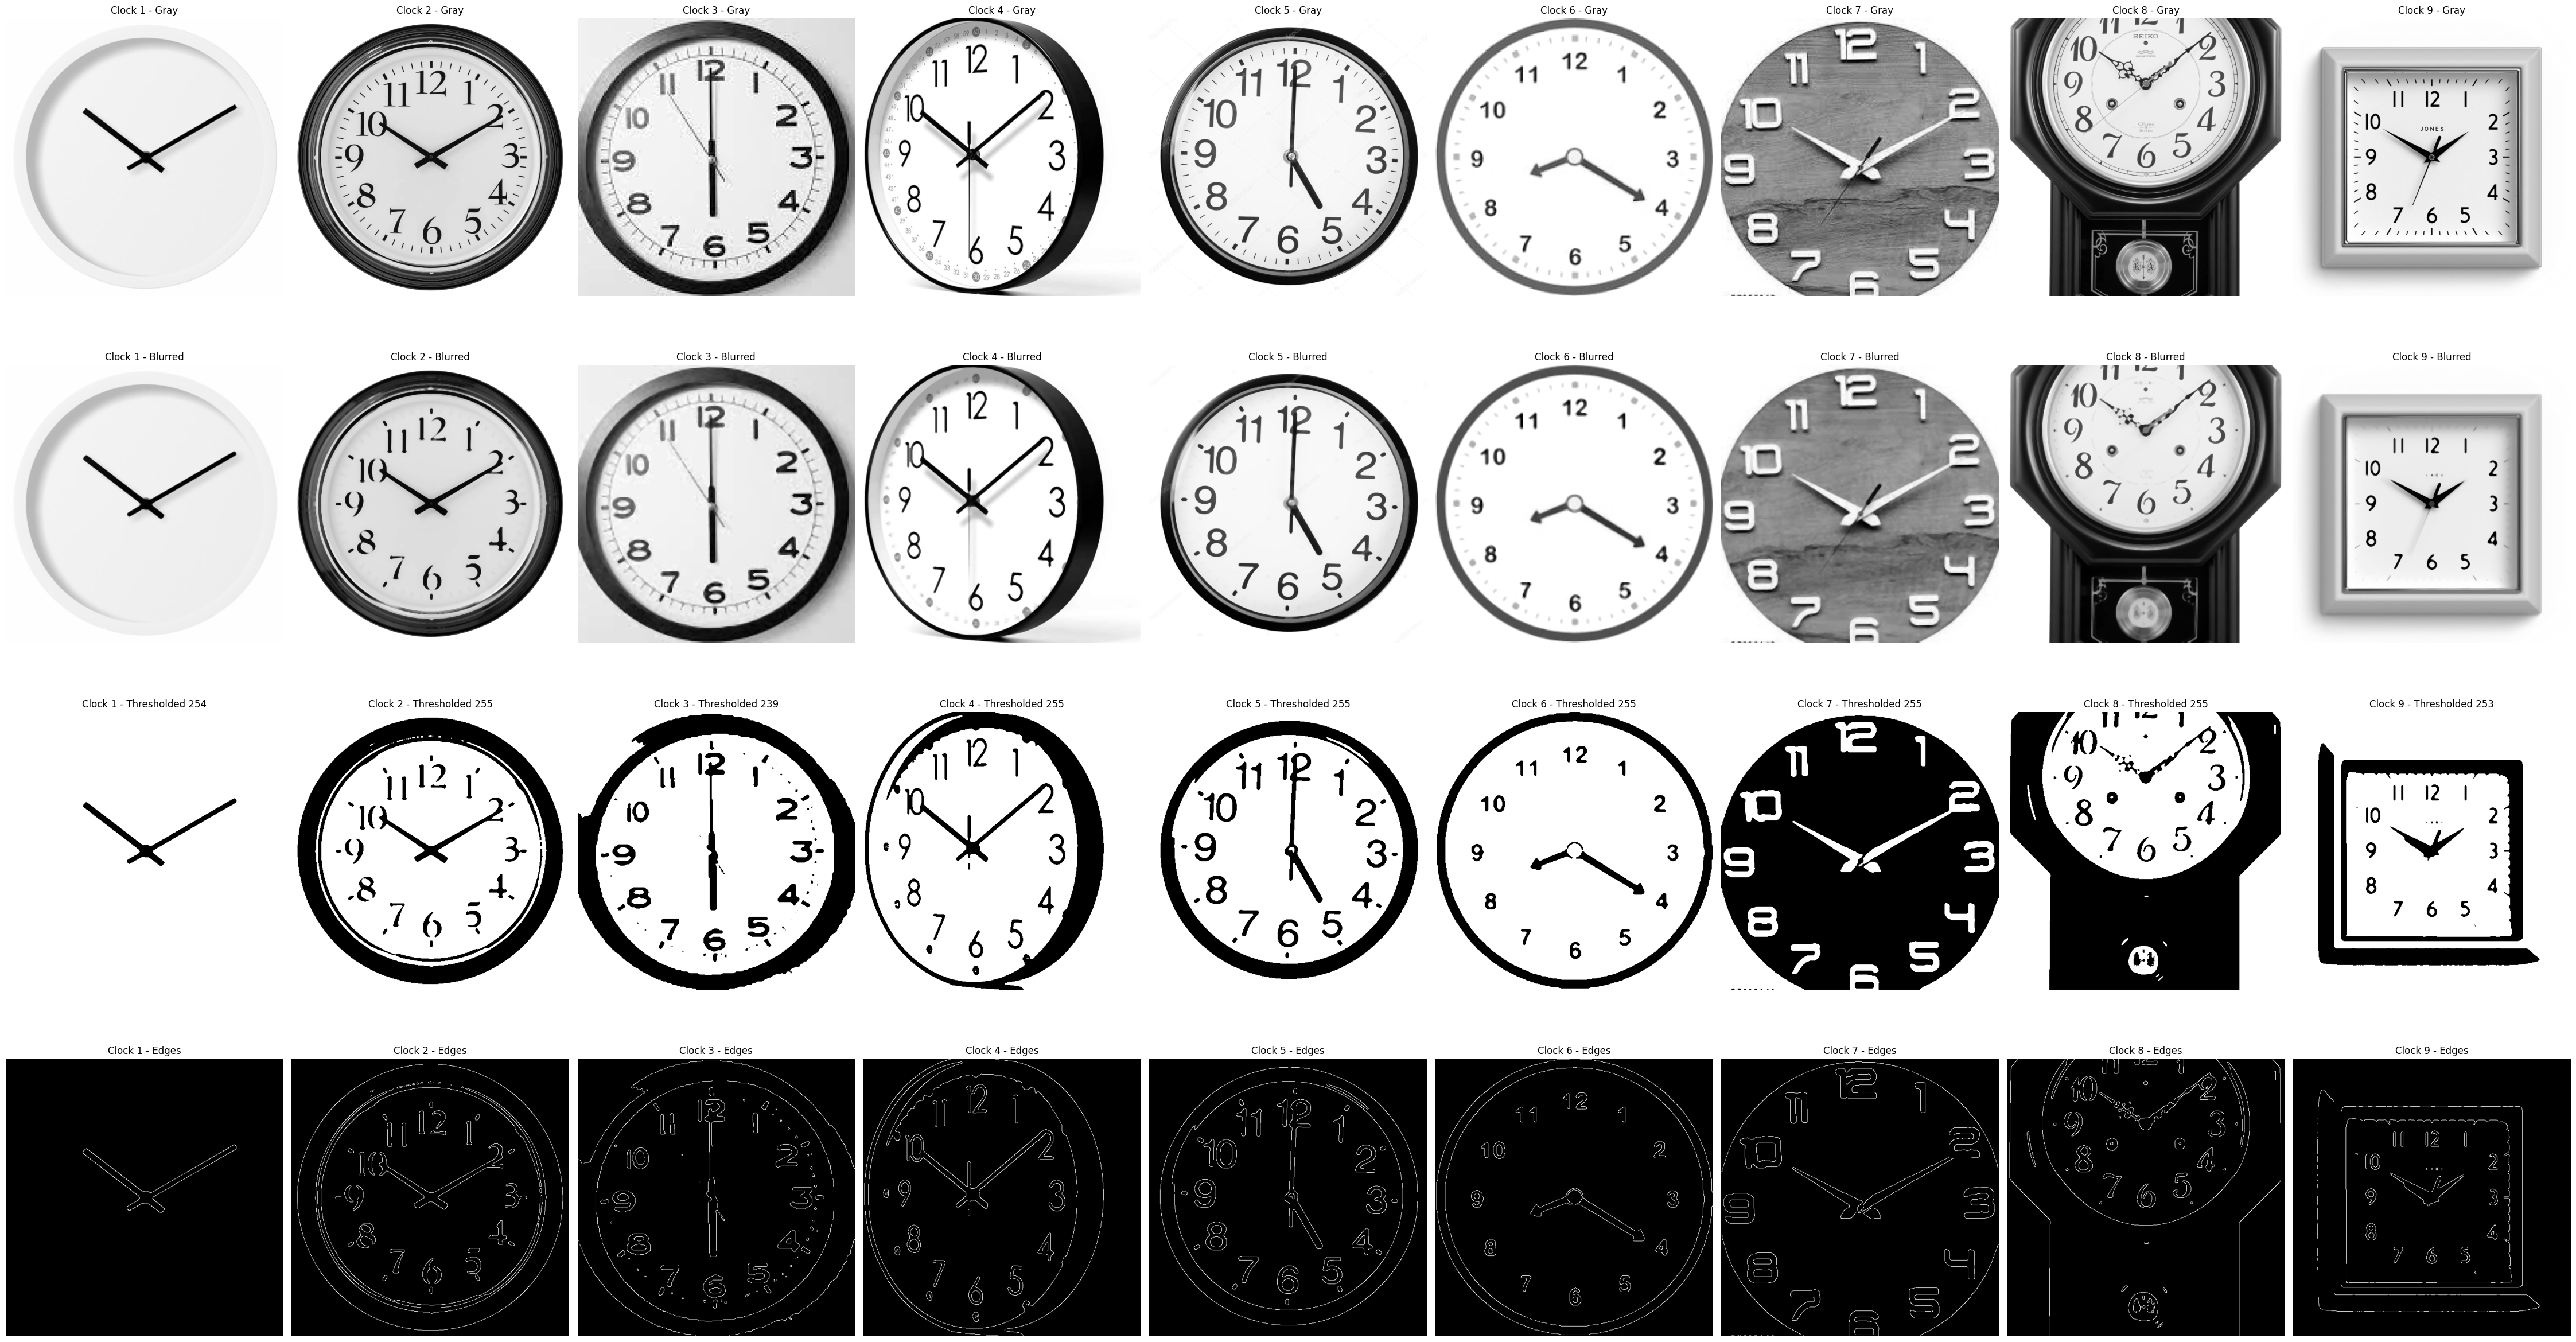

In [2]:
from scipy import stats

def preprocessing(images):
    num_images = len(images)
    image_edges = []

    plt.figure(figsize=(5 * num_images, 25))  # Imposta la dimensione del plot

    for i, img in enumerate(images):
        # Converte l'immagine in scala di grigi
        gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

        plt.subplot(4, num_images, num_images * 0 + i + 1)  # Immagine in scala di grigi
        plt.imshow(gray, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Gray")

        # Riduzione del rumore con filtro median
        blurred = cv2.medianBlur(gray, 7)

        plt.subplot(4, num_images, num_images * 1 + i + 1)  # Immagine sfocata
        plt.imshow(blurred, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Blurred")

        # Calcolo del valore dominante (modal) dell'immagine sfocata
        mode_val = stats.mode(blurred.ravel()).mode  # Accesso corretto al valore modale

        # Determinazione del tipo di threshold in base alla luminosità del colore dominante
        if mode_val > 127:  # Sfondo chiaro
            _, thresholded = cv2.threshold(blurred, mode_val - 80, 255, cv2.THRESH_BINARY)
        else:  # Sfondo scuro
            _, thresholded = cv2.threshold(blurred, mode_val + 80, 255, cv2.THRESH_BINARY)

        plt.subplot(4, num_images, num_images * 2 + i + 1)  # Immagine con threshold
        plt.imshow(thresholded, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Thresholded {mode_val}")
        
        # Applica il Canny Edge Detector
        edges = cv2.Canny(thresholded, 
                          threshold1=250, 
                          threshold2=350
                )
        
        plt.subplot(4, num_images, num_images*3 + i + 1)  # Posizione del subplot per immagine dei bordi
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Edges")

        image_edges.append(edges)

    plt.tight_layout()  # Migliora la disposizione dei subplot
    plt.show()  # Mostra tutti i subplot in una volta

    return image_edges

# Edge detection
edges = preprocessing(images)

### Find the clock center

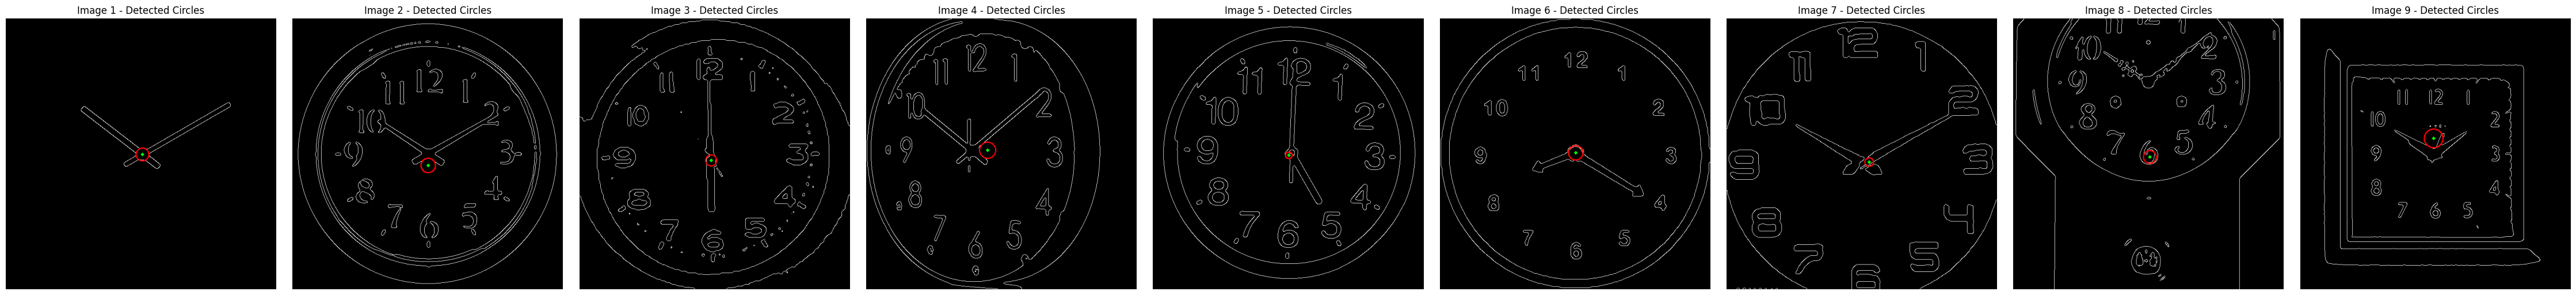

In [3]:
def hough_circle_detector(edges_list, dp=2, min_dist=20, param1=50, param2=30, min_radius=1, max_radius=25, 
                          proximity_threshold=50, filter_closest=True):
    """
    Rileva cerchi in una lista di immagini preprocessate con bordi, usando la trasformata di Hough di OpenCV.
    Opzionalmente filtra per mantenere solo il cerchio più vicino al centro di ogni immagine.

    :param edges_list: Lista di immagini preprocessate (con bordi) su cui eseguire il rilevamento dei cerchi.
    :param dp: Risoluzione inversa dell'accumulatore Hough.
    :param min_dist: Distanza minima tra i centri dei cerchi rilevati.
    :param param1: Primo parametro per Canny (valore alto del threshold).
    :param param2: Soglia accumulatore per il rilevamento di un cerchio.
    :param min_radius: Raggio minimo dei cerchi da rilevare.
    :param max_radius: Raggio massimo dei cerchi da rilevare.
    :param proximity_threshold: Distanza massima dal centro dell'immagine per considerare un cerchio come valido (usato solo se filter_closest=True).
    :param filter_closest: Se True, mantiene solo il cerchio più vicino al centro per ogni immagine.
    :return: Lista contenente il/i cerchio/i più centrale/i per ogni immagine o None se non trovato.
    """
    circles_per_image = []  # Lista per memorizzare i cerchi per ogni immagine
    num_images = len(edges_list)
    
    plt.figure(figsize=(5 * num_images, 5))  # Dimensione del plot per una sola riga

    for i, edges in enumerate(edges_list):
        h, w = edges.shape
        image_center = (w // 2, h // 2)  # Centro dell'immagine
        closest_circle = None
        min_distance = proximity_threshold  # Inizializza con il valore soglia massimo
        detected_circles = []  # Per memorizzare i cerchi di questa immagine

        # Rileva i cerchi utilizzando la trasformata di Hough sui bordi
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=dp, minDist=min_dist,
                                   param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)
        
        # Se ci sono cerchi rilevati, valuta se applicare il filtro
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0, :]:
                x, y, r = circle
                # Calcola la distanza euclidea dal centro dell'immagine
                distance_to_center = np.sqrt((x - image_center[0])**2 + (y - image_center[1])**2)
                
                # Se il filtro è attivo, mantieni solo il cerchio più vicino entro la soglia di distanza
                if filter_closest:
                    if distance_to_center < min_distance:
                        closest_circle = (x, y, r)
                        min_distance = distance_to_center
                else:
                    detected_circles.append((x, y, r))  # Memorizza tutti i cerchi trovati

            # Aggiunge solo il cerchio più vicino, se il filtro è attivo
            if filter_closest:
                circles_per_image.append(closest_circle)
            else:
                circles_per_image.append(detected_circles if detected_circles else None)

        else:
            circles_per_image.append(None)  # Nessun cerchio trovato
        
        # Plot dell'immagine dei bordi con i cerchi rilevati
        output_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Converti edges in BGR per disegnare i cerchi colorati
        plt.subplot(1, num_images, i + 1)
        plt.imshow(output_img)

        # Disegna il/i cerchio/i rilevato/i
        if filter_closest and closest_circle is not None:
            x, y, r = closest_circle
            cv2.circle(output_img, (x, y), r, (255, 0, 0), 2)  # Cerchio rosso
            cv2.circle(output_img, (x, y), 2, (0, 255, 0), 3)  # Punto verde al centro

        elif not filter_closest and detected_circles:
            for (x, y, r) in detected_circles:
                cv2.circle(output_img, (x, y), r, (255, 0, 0), 2)
                cv2.circle(output_img, (x, y), 2, (0, 255, 0), 3)

        plt.imshow(output_img)
        plt.axis('off')
        plt.title(f"Image {i + 1} - Detected Circles")

    plt.tight_layout()
    plt.show()
    
    return circles_per_image

# Rileva il blob centrale nell'immagine
image_circles = hough_circle_detector(edges, filter_closest=True)

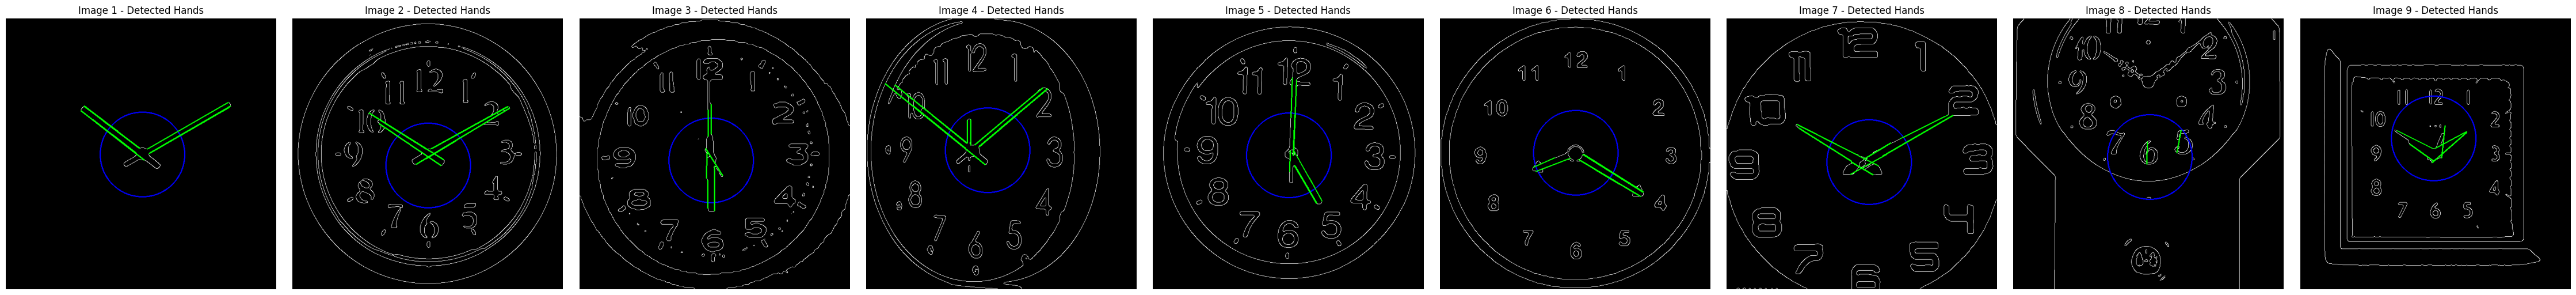

In [4]:
def detect_clock_hands(edges_list, circle_centers, radius_limit=100, threshold=30, line_length=50, line_gap=10, restrict_to_circle=True):
    """
    Detects clock hands in each image of edges_list, with an option to restrict line detection within a radius around the center.

    :param edges_list: List of edge-detected images.
    :param circle_centers: List of detected circle centers for each image.
    :param radius_limit: Maximum radius from the center within which to search for lines.
    :param threshold: The minimum number of intersections to "*detect*" a line.
    :param line_length: Minimum line length to detect.
    :param line_gap: Maximum gap between collinear line segments.
    :param restrict_to_circle: If True, restricts line detection to within the circle; if False, detects lines across the entire image.
    :return: List of detected hands for each image.
    """
    num_images = len(edges_list)
    detected_hands_per_image = []  # List to store detected hands for each image

    plt.figure(figsize=(5 * num_images, 5))  # Set plot size

    for i, (edges, center) in enumerate(zip(edges_list, circle_centers)):
        # Set default center if none is provided
        if center is None:
            cx, cy = edges.shape[1] // 2, edges.shape[0] // 2
        else:
            cx, cy = center[:2]  # Get x, y coordinates of detected circle center

        output_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert edges to BGR for color display
        detected_lines = []  # Store lines detected for current image

        # Perform Hough Line Transform to detect lines
        lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=threshold,
                                minLineLength=line_length, maxLineGap=line_gap)

        # Draw the detection radius circle only if restrict_to_circle is True
        if restrict_to_circle:
            cv2.circle(output_img, (cx, cy), radius_limit, (0, 0, 255), 2)

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Check if either endpoint is within the defined radius limit
                start_inside = np.sqrt((x1 - cx) ** 2 + (y1 - cy) ** 2) <= radius_limit
                end_inside = np.sqrt((x2 - cx) ** 2 + (y2 - cy) ** 2) <= radius_limit

                if restrict_to_circle:
                    # Keep the line if it has one endpoint inside the circle
                    if start_inside or end_inside:
                        detected_lines.append((x1, y1, x2, y2))
                else:
                    # If not restricted, keep all lines
                    detected_lines.append((x1, y1, x2, y2))

            # Draw all detected lines
            for (x1, y1, x2, y2) in detected_lines:
                cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines for detected clock hands

            detected_hands_per_image.append(detected_lines if detected_lines else None)
        else:
            detected_hands_per_image.append(None)

        # Plotting
        plt.subplot(1, num_images, i + 1)
        plt.imshow(output_img)
        plt.axis('off')
        plt.title(f"Image {i + 1} - Detected Hands")

    plt.tight_layout()
    plt.show()

    return detected_hands_per_image

# Example usage
clock_hands = detect_clock_hands(edges, image_circles, threshold=20, restrict_to_circle=True, line_gap=20, line_length=50)

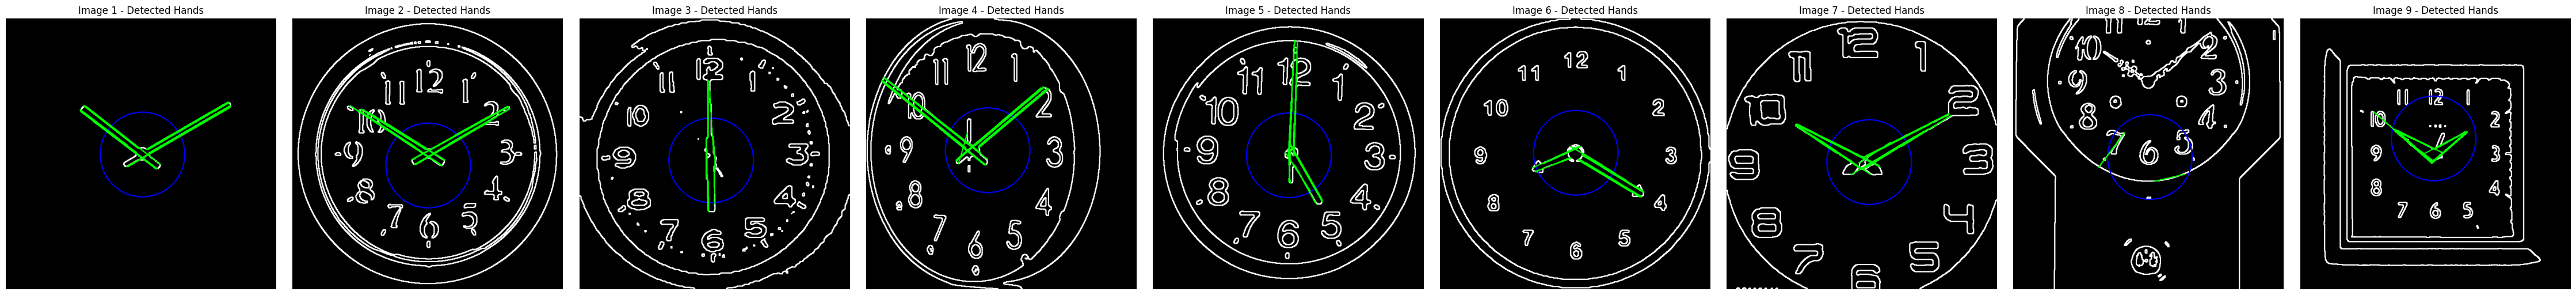

In [5]:
def detect_clock_hands(edges_list, circle_centers, radius_limit=100, threshold=20, line_length=30, line_gap=20, restrict_to_circle=True):
    """
    Detects clock hands in each image of edges_list, with an option to restrict line detection within a radius around the center.
    
    :param edges_list: List of edge-detected images.
    :param circle_centers: List of detected circle centers for each image.
    :param radius_limit: Maximum radius from the center within which to search for lines.
    :param threshold: The minimum number of intersections to "detect" a line.
    :param line_length: Minimum line length to detect.
    :param line_gap: Maximum gap between collinear line segments.
    :param restrict_to_circle: If True, restricts line detection to within the circle; if False, detects lines across the entire image.
    :return: List of detected hands for each image.
    """
    num_images = len(edges_list)
    detected_hands_per_image = []
    dilated_edges = []

    plt.figure(figsize=(5 * num_images, 5))

    for i, (edges, center) in enumerate(zip(edges_list, circle_centers)):
        # Optionally dilate edges to enhance line detection
        edges_dilated = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)
        output_img = cv2.cvtColor(edges_dilated, cv2.COLOR_GRAY2BGR)

        dilated_edges.append(edges_dilated)

        # Determine center of circle or default to image center
        cx, cy = (center[:2] if center is not None else (edges.shape[1] // 2, edges.shape[0] // 2))

        # Perform Hough Line Transform
        lines = cv2.HoughLinesP(edges_dilated.copy(), rho=1, theta=np.pi / 180, threshold=threshold,
                                minLineLength=line_length, maxLineGap=line_gap)
        
        detected_lines = []  # Store lines that meet criteria

        if restrict_to_circle:
            # Draw detection circle only if restricting to radius
            cv2.circle(output_img, (cx, cy), radius_limit, (0, 0, 255), 2)
        
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                start_inside = np.sqrt((x1 - cx) ** 2 + (y1 - cy) ** 2) <= radius_limit
                end_inside = np.sqrt((x2 - cx) ** 2 + (y2 - cy) ** 2) <= radius_limit

                # Append line based on restriction criteria
                if not restrict_to_circle or start_inside or end_inside:
                    detected_lines.append((x1, y1, x2, y2))
                    cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw detected line in green

        detected_hands_per_image.append(detected_lines if detected_lines else None)

        # Plotting
        plt.subplot(1, num_images, i + 1)
        plt.imshow(output_img)
        plt.axis('off')
        plt.title(f"Image {i + 1} - Detected Hands")

    plt.tight_layout()
    plt.show()

    return dilated_edges, detected_hands_per_image

# Example usage
dilated_edges, clock_hands = detect_clock_hands(edges, image_circles, threshold=20, restrict_to_circle=True, line_gap=20, line_length=70)

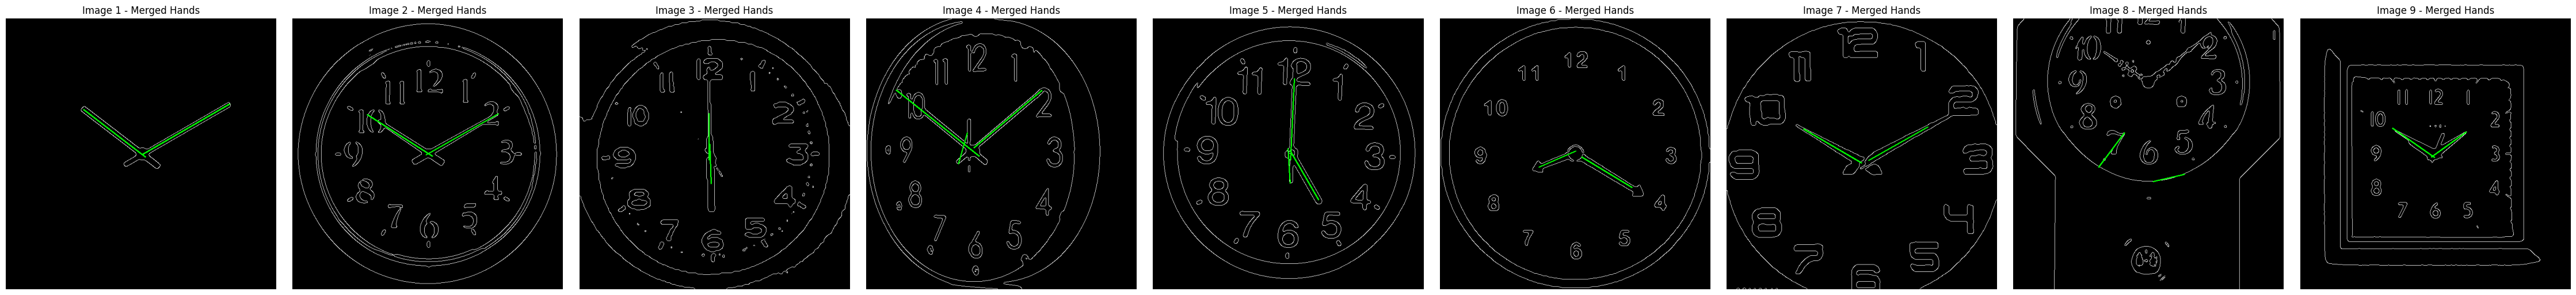

In [6]:
from math import atan2, degrees, sqrt

def calculate_angle(x1, y1, x2, y2):
        """Calcola l'angolo di una linea rispetto all'asse x."""
        return degrees(atan2(y2 - y1, x2 - x1))

def group_and_merge_lines(edges_list, clock_hands, angle_threshold=10, distance_threshold=15):
    """
    Raggruppa e unisce linee simili per ogni immagine in `clock_hands`, usando angolo e distanza.

    :param edges_list: Lista di immagini di edges usata per il plot.
    :param clock_hands: Lista composta da liste di tuple (immagine, lista di linee) per ciascuna immagine.
    :param angle_threshold: Differenza massima di angolo per considerare le linee simili (in gradi).
    :param distance_threshold: Distanza massima per unire linee simili.
    :return: Lista di linee consolidate per ogni immagine.
    """

    def merge_lines(line_group):
        """Unisce un gruppo di linee in una singola linea media."""

        x1_coords, x2_coords, y1_coords, y2_coords = [], [], [], []
        
        for (x1, y1, x2, y2) in line_group:
            x1_coords.append(x1)
            x2_coords.append(x2)
            y1_coords.append(y1)
            y2_coords.append(y2)
             

        return int(np.mean(x1_coords)), int(np.mean(y1_coords)), int(np.mean(x2_coords)), int(np.mean(y2_coords))

    consolidated_lines_per_image = []

    plt.figure(figsize=(5 * len(edges_list), 5))

    for idx, lines in enumerate(clock_hands): # Per ogni immagine

        # Verifica che ci siano linee per l'immagine corrente
        if lines is None:
            consolidated_lines_per_image.append(None)
            continue

        # Step 1: Raggruppa linee simili in base all'angolo
        angle_groups = {}
        for line in lines:
            # Ensure the line has exactly four coordinates
            if len(line) == 4:
                x1, y1, x2, y2 = line
                angle = calculate_angle(x1, y1, x2, y2)
                found_group = False
                for group_angle in list(angle_groups):
                    if abs(angle - group_angle) < angle_threshold:
                        angle_groups[group_angle].append((x1, y1, x2, y2))
                        found_group = True
                        break
                if not found_group:
                    angle_groups[angle] = [(x1, y1, x2, y2)]

        # Step 2: All'interno dei gruppi angolari, unisce linee vicine
        merged_lines = []
        for line_group in angle_groups.values():
                # Unisce tutte le linee nel gruppo temporaneo
                merged_lines.append(merge_lines(line_group))

        consolidated_lines_per_image.append(merged_lines)

        # Step 3: Plotting
        output_img = cv2.cvtColor(edges_list[idx], cv2.COLOR_GRAY2BGR)  # Converte l'immagine in BGR per plot
        for (x1, y1, x2, y2) in merged_lines:
            cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Disegna linee consolidate in verde

        # Assicura che ogni immagine venga plottata correttamente
        plt.subplot(1, len(edges_list), idx + 1)
        plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))  # Converte BGR a RGB per Matplotlib
        plt.axis('off')
        plt.title(f"Image {idx + 1} - Merged Hands")

    plt.tight_layout()
    plt.show()

    return consolidated_lines_per_image

# Example usage
grouped_clock_hands = group_and_merge_lines(edges, clock_hands, angle_threshold=20, distance_threshold=15)

In [17]:
grouped_clock_hands

[[(184, 215, 330, 327), (323, 321, 529, 202)],
 [(316, 322, 487, 225), (177, 227, 331, 325)],
 [(308, 297, 311, 390), (306, 334, 306, 224)],
 [(255, 305, 415, 170), (71, 169, 267, 325), (218, 343, 239, 270)],
 [(325, 334, 334, 142), (324, 312, 391, 428), (319, 307, 324, 389)],
 [(335, 327, 454, 399), (234, 351, 321, 313)],
 [(182, 261, 319, 341), (336, 335, 476, 256)],
 [(202, 351, 263, 270), (331, 385, 405, 368)],
 [(218, 259, 317, 328), (310, 327, 392, 268)]]

Image 1
Image 2
Image 3
Image 4
Image 5
Image 6
Image 7
Image 8
Image 9


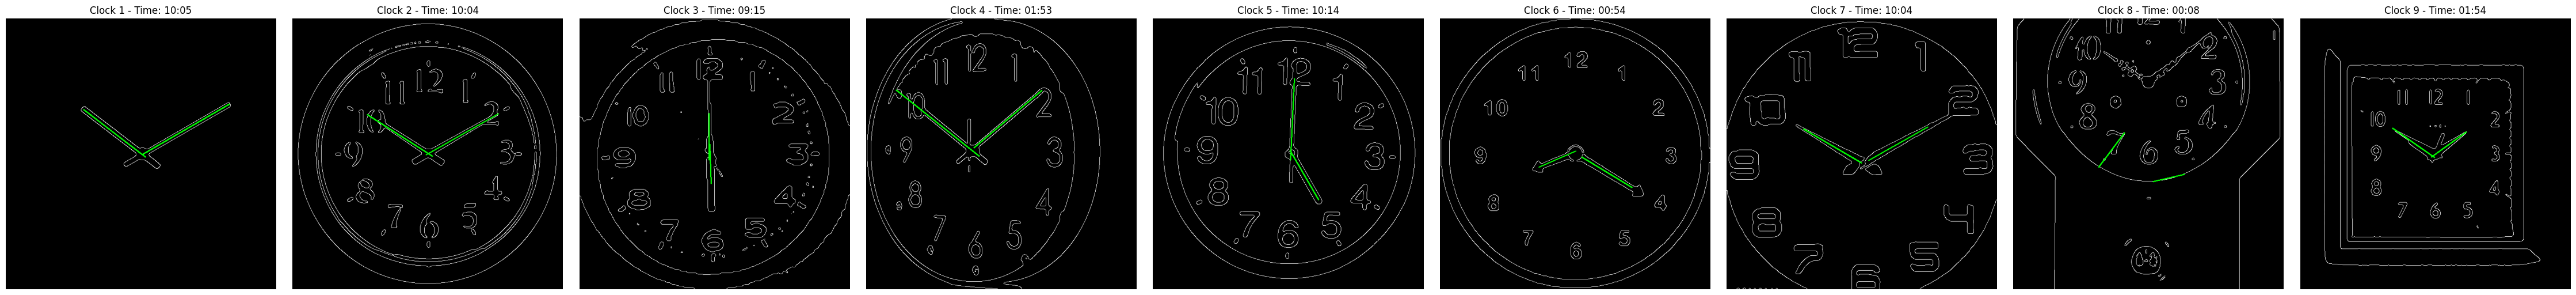

In [21]:
import math

def calculate_angle(x1, y1, x2, y2):
    """Calcola l'angolo di una linea rispetto alla verticale, in senso orario da 12."""
    dx = x2 - x1
    dy = y1 - y2  # Nota: invertiamo perché l'asse y è invertito in immagini
    angle = math.degrees(math.atan2(dy, dx))
    angle = (angle + 360) % 360  # Porta l'angolo tra 0 e 360 gradi
    return angle

def calculate_time_from_hands(hands):
    """
    Calcola l'orario in base alle lancette fornite.

    :param hands: Lista di coordinate delle due lancette (x1, y1, x2, y2).
    :return: Stringa che rappresenta l'orario in formato "HH:MM".
    """
    if len(hands) < 2:
        return "Time not detected"

    # Estrarre le lancette
    minute_hand = hands[0]
    hour_hand = hands[1]

    # Calcola la lunghezza delle lancette
    minute_length = np.sqrt((minute_hand[2] - minute_hand[0]) ** 2 + (minute_hand[3] - minute_hand[1]) ** 2)
    hour_length = np.sqrt((hour_hand[2] - hour_hand[0]) ** 2 + (hour_hand[3] - hour_hand[1]) ** 2)

    # Determina quale è la lancetta dei minuti e quale è quella delle ore
    if minute_length < hour_length:
        minute_hand, hour_hand = hour_hand, minute_hand

    # Calcolo dell'angolo per ciascuna lancetta
    minute_angle = calculate_angle(minute_hand[0], minute_hand[1], minute_hand[2], minute_hand[3])
    hour_angle = calculate_angle(hour_hand[0], hour_hand[1], hour_hand[2], hour_hand[3])

    # Calcolo delle ore e dei minuti
    minutes = int((minute_angle / 6) % 60)  # Ogni 6 gradi è un minuto
    hours = (int(hour_angle / 30) + (minutes // 60)) % 12  # Ogni 30 gradi è un'ora; aggiustamento ore con minuti

    return f"{int(hours):02}:{int(minutes):02}"

def plot_clock_times(edges_list, grouped_clock_hands):
    """
    Plotta le immagini e l'orario calcolato in base alle lancette.

    :param edges_list: Lista delle immagini originali.
    :param grouped_clock_hands: Lista di linee consolidate per ogni immagine.
    """
    plt.figure(figsize=(5 * len(edges_list), 5))

    for idx, (img, hands) in enumerate(zip(edges_list, grouped_clock_hands)):
        # Calcola l'orario
        if hands is None or len(hands) == 0:
            time_string = "Time not detected"
        else:
            # Se ci sono più di 2 lancette, prendi le 2 più lunghe
            if len(hands) > 2:
                hands = sorted(hands, key=lambda h: np.sqrt((h[2] - h[0]) ** 2 + (h[3] - h[1]) ** 2), reverse=True)[:2]
            print("Image", idx+1)
            time_string = calculate_time_from_hands(hands)

        # Creazione dell'immagine con le lancette disegnate
        output_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for (x1, y1, x2, y2) in hands:
            cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Disegna linee consolidate in verde

        # Plotta l'immagine originale con l'orario calcolato
        plt.subplot(1, len(edges_list), idx + 1)
        plt.imshow(output_img)  # Mostra immagine
        plt.axis('off')
        plt.title(f"Clock {idx + 1} - Time: {time_string}")

    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
plot_clock_times(edges, grouped_clock_hands)